### Get data from Steam Community Market API and save to csv

In [3]:
# Obtaining the data + inputting items seeking for

import re
import requests
import pandas as pd

dailyCookie = "76561199704981720%7C%7CeyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MTcwQl8yNDkzRTBDMF80QkU4NSIsICJzdWIiOiAiNzY1NjExOTk3MDQ5ODE3MjAiLCAiYXVkIjogWyAid2ViOmNvbW11bml0eSIgXSwgImV4cCI6IDE3MTkxNzU1NDMsICJuYmYiOiAxNzEwNDQ4MzYxLCAiaWF0IjogMTcxOTA4ODM2MSwgImp0aSI6ICIwRUY1XzI0OUJBQzg0XzZCRjZDIiwgIm9hdCI6IDE3MTgzNjI3ODYsICJydF9leHAiOiAxNzM2NjE4ODA2LCAicGVyIjogMCwgImlwX3N1YmplY3QiOiAiODEuMTA1LjIwMS41NyIsICJpcF9jb25maXJtZXIiOiAiOTAuMTk3Ljc5LjEzMyIgfQ.C8Ydk63uaYkfiZz-LVCYKs7Pl5KanHQ6SdnHqsIi2foA4IY04WL4HSrF90t5DyTTuXD5CfeIaoUAgFd3tOJaBg"
items = ["Glove Case Key", "Officer Jacques Beltram | Gendarmerie Nationale", "Kilowatt Case", "AK-47 | Blue Laminate (Factory New)", "Glove Case"]

def fetch_item_to_df(item):
    # get historical price data of item from API
    url = "https://steamcommunity.com/market/pricehistory/"
    params = {
        'country': 'US',
        'currency': '1',
        'appid': '730',
        'market_hash_name': item
    }
    cookies = {'steamLoginSecure': dailyCookie}

    response = requests.get(url, params=params, cookies=cookies)
    jsonData = response.json()

    # print error message if request failed
    if response.status_code != 200:
        print(f"Failed to fetch data for {item}. Status code: {response.status_code}")
        return None

    # convert and clean data to dataframe object
    price_history = jsonData['prices']
    price_history_df = pd.DataFrame(price_history, columns=['date', 'price_usd', 'volume'])
    price_history_df['date'] = pd.to_datetime(price_history_df['date'].str[:-7], format='%b %d %Y')
    price_history_df['volume'] = pd.to_numeric(price_history_df['volume'])
    price_history_df.set_index('date', inplace=True)

    return price_history_df


def sanitize_filename(filename):
    """Sanitizes the filename to ensure it is valid for most operating systems."""
    filename = re.sub(r'[\\/*?:"<>|]', '_', filename)  # Replace disallowed characters with underscore
    filename = re.sub(r'\s+', '_', filename)  # Replace spaces with underscores
    return filename

def save_item_to_csv(item):
    csvData = './data/'+ sanitize_filename(item) +'.csv'
    fetch_item_to_df(item).to_csv(csvData, index=True)


## fetch and save data in items to csv - Uncomment this when checking new item or updating previous datasets

# for index, item in enumerate(items):
#     save_item_to_csv(item)






### Item Verification

In [4]:
# Call the method (From Get Data notebook) to get current_item dataframe

from matplotlib import pyplot as plt

current_item = fetch_item_to_df(items[4])

# shows what current item is, note: Array item stats with 0.
print(items[4])
print(current_item.head())



Glove Case
            price_usd  volume
date                         
2016-11-29      6.457   53686
2016-11-30      3.576   49360
2016-12-01      2.717   48668
2016-12-02      2.083   54474
2016-12-03      1.616   64918


### Historic Price (0)  

In [5]:
# > Historic Price (Basic)


import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):
    # Filtering the data based on the date range
    mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
    filtered_data = df.loc[mask]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['price_usd'], mode='lines+markers', name='Price USD'))

    # Formatting
    fig.update_layout(
        title='Median Price over time (Historic Chart)',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(  # Added lines for range slider
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        showlegend=True

        )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)





interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date', step=1), Da…

<function __main__.update_graph(start_date, end_date)>

### Volume Indicatior (1)

In [6]:
# > Volume Indicatior (1)

import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):
    # Filtering the data based on the date range
    mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
    filtered_data = df.loc[mask]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Bar(x=filtered_data.index, y=filtered_data['volume'], name='Price USD'))

    # Formatting
    fig.update_layout(
        title='Volume Chart',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(  # Added lines for range slider
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)



interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date', step=1), Da…

<function __main__.update_graph(start_date, end_date)>

### Moving Averages (2)

In [7]:
# # SIMPLE Moving Average (SMA)                            
#  | Part of Moving Averages (2) block


import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# calculates the 7-day moving average. 
# change window = to change period for average.
df['smoothened_price'] = df['price_usd'].rolling(window=2).mean()

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):
    # Filtering the data based on the date range
    mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))
    filtered_data = df.loc[mask]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['smoothened_price'], mode='lines', name='Smoothened Price'))

    # Formatting
    fig.update_layout(
        title='Simple Moving Average Chart',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(  # Added lines for range slider
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        showlegend=True

        )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)


interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date', step=1), Da…

<function __main__.update_graph(start_date, end_date)>

In [8]:
 # SIMPLE Moving Average (SMA) -  CANDLESTICK  
 # | Part of Moving Averages (2) block

# NOTE: this produces candlesticks based on (specified time frame e.g. Weekly) data


import plotly.graph_objects as go
import pandas as pd
from ipywidgets import interact, DatePicker
import numpy as np

# renames current item to df
df = current_item

# Resample the data to weekly timeframe
# NOTE: Range can be altered: 'W' (week), 'M' (Month), '2D' (2 Days)
new_data = df.resample('5M').agg({
    'price_usd': ['max', 'min', 'mean'],
    'volume': 'sum'
})

# Flatten the multi-level columns and rename
new_data.columns = ['high', 'low', 'mean', 'volume']
# print(new_data.head(10))

# Function to update the graph based on the selected date range
def update_graph(start_date, end_date):


    mask = (new_data.index >= pd.to_datetime(start_date)) & (new_data.index <= pd.to_datetime(end_date))
    filtered_data = new_data.loc[mask]

    
    # Creating the candlestick chart
    fig = go.Figure(data=[go.Candlestick(x=filtered_data.index,
                                         open=filtered_data['mean'],
                                         high=filtered_data['high'],
                                         low=filtered_data['low'],
                                         close=filtered_data['mean'],
                                         name='Candlestick')])
    


    # Formatting
    fig.update_layout(
        title='SMA - Candlestick',
        xaxis_title='Date',
        yaxis_title='Price USD',
        yaxis=dict(
            title='Price USD',
            titlefont_size=16,
            tickfont_size=14,
        ),
        
        showlegend=True
    )

    fig.show()


# Creating interactive widgets for date selection
start_date_picker = DatePicker(description='Start Date', value=current_item.index[0], disabled=False)
end_date_picker = DatePicker(description='End Date', value=current_item.index[-1], disabled=False)

# Display the interactive widget
interact(update_graph, start_date=start_date_picker, end_date=end_date_picker)


interactive(children=(DatePicker(value=Timestamp('2016-11-29 00:00:00'), description='Start Date', step=1), Da…

<function __main__.update_graph(start_date, end_date)>

In [9]:
#  EXPONENTIAL Moving Average (EMA)
# | Part of Moving Averages (2) block


# !!!!!!!!!!!!!!!!!! NOTE: NOT IMPLMENTED !!!!!!!!!!!!!!!!!!!!!!!!





### Linear regression model

Coefficient: 0.0017475313616116229
Intercept: -1287.8064303829265


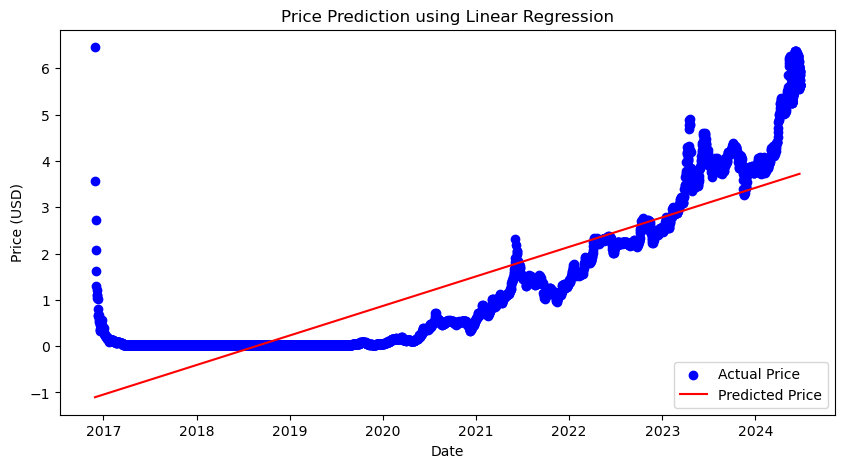

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

current_item['date_ordinal'] = current_item.index.map(pd.Timestamp.toordinal)
X = current_item['date_ordinal'].values.reshape(-1, 1)
y = current_item['price_usd'].values

# train test split (first 80% train, last 20% test)
split_point = int(len(X) * 0.8)  
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# make predictions
y_pred = model_lr.predict(X)

print(f"Coefficient: {model_lr.coef_[0]}")  # slope of the model
print(f"Intercept: {model_lr.intercept_}")  # intercept of the model

plt.figure(figsize=(10, 5))
plt.scatter(current_item.index, y, color='blue', label='Actual Price')
plt.plot(current_item.index, y_pred, color='red', label='Predicted Price')
plt.title('Price Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()